ベイズ最適化でハイパーパラメータを探してみる

# 準備

In [4]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.datasets import make_classification, make_blobs
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)


import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import time

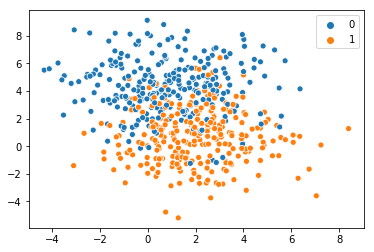

In [5]:
# X_orig, y_orig = make_classification(n_samples = 500, class_sep=0.0001)
X_orig, y_orig = make_blobs(n_samples=550, centers=2, n_features=2,
                  random_state=0, cluster_std=2)
sns.scatterplot(X_orig[:,0], X_orig[:,1], hue=y_orig)

In [6]:
X_train, y_train = X_orig[:500,:], y_orig[:500]
X_test, y_test = X_orig[500:,:], y_orig[500:]

# 目的関数を作る

In [ ]:
def make_objective(X, y):
    def cv_score(C, kernel):
            

# モデル設定

In [7]:
params_fix = dict(
  degree=3,
  gamma="scale",
  class_weight="balanced"
)
params_opt = dict(
  C=[0.001, 0.01, 0.1, 1, 10, 100],
  kernel=["rbf", "linear", "poly", "sigmoid"]
)
clf = SVC(**params_fix, probability=True, random_state=1)

In [8]:
cv = GridSearchCV(clf, params_opt, cv=3, scoring="roc_auc", verbose=3, n_jobs=-1)

# ハイパーパラメータ探索

In [9]:
start_time = time.perf_counter()
fit = cv.fit(X_train, y_train)
print(f"elapsed {time.perf_counter() - start_time}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.4s


elapsed 21.913246695010457


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   21.8s finished


# 結果の確認

In [10]:
cv_results = pd.DataFrame(cv.cv_results_)
cv_results.head(2)

/Users/hotoku/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/hotoku/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/hotoku/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/hotoku/anaconda/lib/pyth

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.031327,0.001630,0.012385,0.005539,0.001,rbf,"{'C': 0.001, 'kernel': 'rbf'}",0.917814,0.873064,0.835221,0.875446,0.033744,15,0.865837,0.883658,0.894614,0.881370,0.011859
1,0.018937,0.006306,0.002869,0.000061,0.001,linear,"{'C': 0.001, 'kernel': 'linear'}",0.933878,0.909782,0.886179,0.909994,0.019464,1,0.896320,0.909740,0.919643,0.908568,0.009557


In [11]:
cv.best_params_

{'C': 0.001, 'kernel': 'linear'}

In [12]:
clf_opt = SVC(**cv.best_params_, **params_fix, probability=True, random_state=1)
start_time = time.perf_counter()
fit_opt = clf_opt.fit(X_train, y_train)
print(f"elapsed {time.perf_counter() - start_time}")

elapsed 0.01907005099928938


In [13]:
def print_metrics(fit, X, y):
    pred = fit.predict(X)
    prob = fit.predict_proba(X)
    print(f"""
    accuracy={accuracy_score(y, pred)}
    precision={precision_score(y, pred)}
    recall={recall_score(y, pred)}
    auc={roc_auc_score(y, prob[:,1])}
    """)

In [14]:
print("====train====")
print_metrics(fit, X_train, y_train)
print("====test====")
print_metrics(fit, X_test, y_test)

====train====

    accuracy=0.826
    precision=0.8313253012048193
    recall=0.8214285714285714
    auc=0.9083221326164874
    
====test====

    accuracy=0.84
    precision=0.8
    recall=0.8695652173913043
    auc=0.8872785829307569
    


CVで一番良い結果がでるパラメータを選んだので、訓練での精度とテストでの精度が同じくらいになっている